# Dermanalyze

* actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
* basal cell carcinoma (bcc)
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses) (bkl)
* dermatofibroma (df)
* melanoma (mel)
* melanocytic nevi (nv) 
* vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage) (vasc)
* normal skin (include mole) or other skin diseases (acne, milia) (unk)

In [ ]:
# !pip install pip --upgrade
# !pip install tensorflow
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install kaggle
# !pip install opencv-python
# !pip install keras-tuner

In [1]:
import os
import pathlib
import shutil
from collections import Counter

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list

## Data Extraction

In [13]:
# mount google drive and move working directory to /content/drive/MyDrive/Dermanalyze3
# if not os.path.ismount("/content/drive"):
#     drive.mount('/content/')
# %cd /content/drive/MyDrive/Dermanalyze3

In [2]:
# define directory names 
base_dir = os.getcwd()
print(base_dir)

hmnist_dir = os.path.join(base_dir, "mnist-ham10000")
isic18_val_dir = os.path.join(base_dir, "isic18-val")
isicarv_dir = os.path.join(base_dir, "isic-archieve")
dermnetnz_dir = os.path.join(base_dir, "dermnetnz")
unk_dir = os.path.join(base_dir, "unknown")

hmnist_test_dir = os.path.join(base_dir, "mnist-ham10000-test")

images_dir = os.path.join(base_dir, "images")
if not os.path.isdir(images_dir):
    os.mkdir(images_dir)
cc_images_dir = os.path.join(base_dir, "cc_images")
if not os.path.isdir(cc_images_dir):
    os.mkdir(cc_images_dir)

models_dir = os.path.join(base_dir, "models")
if not os.path.isdir(models_dir):
    os.mkdir(models_dir)
checkpoints_dir = os.path.join(base_dir, "checkpoints")
if not os.path.isdir(checkpoints_dir):
    os.mkdir(checkpoints_dir)
tflite_dir = os.path.join(base_dir, "tflites")
if not os.path.isdir(tflite_dir):
    os.mkdir(tflite_dir)

C:\Users\aulia\Bangkit\Dermanalyze-ML


### Prerequisite

In [ ]:
# upload kaggle api token (kaggle.json)
# files.upload()

In [ ]:
# !rm ~/.kaggle/kaggle.json
# !rmdir ~/.kaggle

In [ ]:
# copy kaggle api token to ~/.kaggle anda delete the uploaded file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !rm kaggle.json

### Train and Validation Set

#### HMNIST 

In [ ]:
# create dir
!mkdir {hmnist_dir}

In [ ]:
# download dataset and unzip it
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 --force
!unzip -nq skin-cancer-mnist-ham10000.zip -d {hmnist_dir}

100% 5.19G/5.20G [00:24<00:00, 260MB/s]
100% 5.20G/5.20G [00:24<00:00, 227MB/s]


#### ISIC-2018 Validation

In [18]:
# create dir
!mkdir {isic18_val_dir}

In [ ]:
# download dataset and unzip it
!wget --no-cache https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip
!unzip -nq ISIC2018_Task3_Validation_Input.zip -d {isic18_val_dir}

--2022-05-22 23:10:29--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.130.193
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.130.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53292381 (51M) [application/zip]
Saving to: ‘ISIC2018_Task3_Validation_Input.zip’

ISIC2018_Task3_Vali 100%[===================>]  50.82M   601KB/s    in 68s     

2022-05-22 23:11:39 (762 KB/s) - ‘ISIC2018_Task3_Validation_Input.zip’ saved [53292381/53292381]



In [ ]:
# download ground truth and unzip it
!wget --no-cache https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip
!unzip -nq ISIC2018_Task3_Validation_GroundTruth.zip -d {isic18_val_dir}

--2022-05-22 23:16:00--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.242.132
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.242.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7619 (7.4K) [application/zip]
Saving to: ‘ISIC2018_Task3_Validation_GroundTruth.zip’

ISIC2018_Task3_Vali 100%[===================>]   7.44K  --.-KB/s    in 0s      

2022-05-22 23:16:02 (273 MB/s) - ‘ISIC2018_Task3_Validation_GroundTruth.zip’ saved [7619/7619]



#### ISIC Archieve

In [ ]:
!mkdir {isicarv_dir}

In [15]:
# download dataset and unzip it
!kaggle datasets download -d jnegrini/skin-lesions-act-keratosis-and-melanoma --force
!unzip -nq skin-lesions-act-keratosis-and-melanoma.zip -d {isicarv_dir}

100%|█████████████████████████████████████▉| 1.46G/1.46G [08:46<00:00, 3.52MB/s]
100%|██████████████████████████████████████| 1.46G/1.46G [08:46<00:00, 2.98MB/s]


### Test Set

In [ ]:
# unzip test set
!mkdir {hmnist_test_dir}

In [ ]:
# download dataset and unzip it
!wget --no-cache https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip
!unzip -nq ISIC2018_Task3_Test_Images.zip -d {hmnist_test_dir}

## Data Exploration

### Train and Validation Set

#### HMNIST

In [4]:
os.listdir(hmnist_dir)

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'ham10000_images_part_2',
 'hmnist_28_28_RGB.csv',
 'ham10000_images_part_1',
 'hmnist_28_28_L.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [73]:
raw_hmnist_df = pd.read_csv(os.path.join(hmnist_dir, "HAM10000_metadata.csv"))
raw_hmnist_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
# view the characteristics of the data
raw_hmnist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


The `age` column has missing values, but it's not such an important feature that it can be ignored

In [9]:
print("Unique Lesion:\t", raw_hmnist_df['lesion_id'].nunique()) 
print("Unique Image:\t", raw_hmnist_df['image_id'].nunique())
print("Unique Label:\t", raw_hmnist_df['dx'].unique()) # label names

Unique Lesion:	 7470
Unique Image:	 10015
Unique Label:	 ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


The number of images is more than the number of lesions, this indicates 1 lesion has more than 1 image

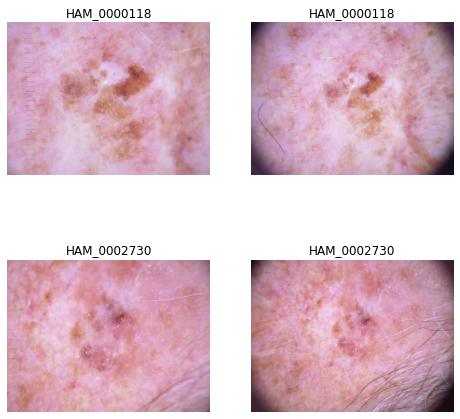

In [10]:
# plot images that have the same lesion_id
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(columns*rows):
    img = plt.imread(os.path.join(hmnist_dir, "HAM10000_images_part_1", raw_hmnist_df['image_id'][i]+".jpg"))
    fig.add_subplot(rows, columns, i+1)
    plt.title(raw_hmnist_df['lesion_id'][i])
    plt.imshow(img)
    plt.axis("off")    
plt.show()

The duplicate lesions have the same image

In [11]:
# view data distribution in each label
raw_hmnist_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

The number of images in each label differs greatly, this indicates the data is not balanced (imbalanced data)

#### ISIC-2018 Validation

In [13]:
print(os.listdir(isic18_val_dir))
print(os.listdir(os.path.join(isic18_val_dir, "ISIC2018_Task3_Validation_GroundTruth")))

['ISIC2018_Task3_Validation_Input', 'ISIC2018_Task3_Validation_GroundTruth']
['ATTRIBUTION.txt', 'ISIC2018_Task3_Validation_GroundTruth.csv', 'LICENSE.txt']


In [74]:
raw_isicval_df = pd.read_csv(os.path.join(isic18_val_dir, "ISIC2018_Task3_Validation_GroundTruth", "ISIC2018_Task3_Validation_GroundTruth.csv"))
raw_isicval_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0034321,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0034322,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0034323,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,ISIC_0034324,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0034325,0.0,1.0,0.0,0.0,0.0,0.0,0.0


label on one-hot encoded format

In [15]:
# view the characteristics of the data
raw_isicval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   193 non-null    object 
 1   MEL     193 non-null    float64
 2   NV      193 non-null    float64
 3   BCC     193 non-null    float64
 4   AKIEC   193 non-null    float64
 5   BKL     193 non-null    float64
 6   DF      193 non-null    float64
 7   VASC    193 non-null    float64
dtypes: float64(7), object(1)
memory usage: 12.2+ KB


In [99]:
# check duplicates data
len(raw_isicval_df['image'].unique())

193

In [16]:
# view data distribution in each label
raw_isicval_df[['NV', 'BKL', 'MEL', 'BCC', 'AKIEC', 'VASC', 'DF']].value_counts()

NV   BKL  MEL  BCC  AKIEC  VASC  DF 
1.0  0.0  0.0  0.0  0.0    0.0   0.0    123
0.0  1.0  0.0  0.0  0.0    0.0   0.0     22
     0.0  1.0  0.0  0.0    0.0   0.0     21
          0.0  1.0  0.0    0.0   0.0     15
               0.0  1.0    0.0   0.0      8
                    0.0    1.0   0.0      3
                           0.0   1.0      1
dtype: int64

In [17]:
# check if there're same images
set(raw_hmnist_df['image_id'].values).intersection(raw_isicval_df['image'].values)

set()

#### ISIC Archieve

In [100]:
print(os.listdir(isicarv_dir))
print(os.listdir(os.path.join(isicarv_dir, "ISIC-images")))

['ISIC-images']
['metadata.csv', 'Images']


In [75]:
raw_isicarv_df = pd.read_csv(os.path.join(isicarv_dir, "ISIC-images", "metadata.csv"))
raw_isicarv_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,5436e3acbae478396759f0d3,ISIC_0000002,mel,histopathology,60.0,female,upper extremity
1,5436e3acbae478396759f0d7,ISIC_0000004,mel,histopathology,80.0,male,posterior torso
2,5436e3adbae478396759f0e9,ISIC_0000013,mel,histopathology,30.0,female,posterior torso
3,5436e3aebae478396759f0fb,ISIC_0000022,mel,histopathology,55.0,female,lower extremity
4,5436e3aebae478396759f103,ISIC_0000026,mel,histopathology,30.0,female,lower extremity


In [76]:
# view the characteristics of the data
raw_isicarv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3101 entries, 0 to 3100
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     3101 non-null   object 
 1   image_id      3101 non-null   object 
 2   dx            3101 non-null   object 
 3   dx_type       2659 non-null   object 
 4   age           3009 non-null   float64
 5   sex           3004 non-null   object 
 6   localization  2894 non-null   object 
dtypes: float64(1), object(6)
memory usage: 169.7+ KB


The `dx_type`, `age`, `sex`, and `localization` columns have missing values, but it's not such an important feature that it can be ignored

In [101]:
# check data duplicates
len(raw_isicarv_df['image_id'].unique())

2941

The number of unique `image_id` is 2941, while in the dataframe it's written 3101, this indicates that there is duplicate data

In [24]:
# # view data distribution in each label
raw_isicarv_df['dx'].value_counts()

mel      900
akiec    600
bcc      600
bkl      600
vasc     275
df       126
Name: dx, dtype: int64

In [25]:
# check if there're same images
print(set(raw_hmnist_df['image_id'].values).intersection(raw_isicarv_df['image_id'].values))
print(set(raw_isicval_df['image'].values).intersection(raw_isicarv_df['image_id'].values))

set()
set()


#### DermNet NZ

In [26]:
os.listdir(dermnetnz_dir)

['df', 'bkl', 'vasc', 'bcc', 'akiec', 'mel', 'nv']

In [77]:
# create dermnetnz dataframe
dermnetnz_data = []
for label in os.listdir(dermnetnz_dir):
    dermnetnz_image_ids = [os.path.splitext(filename)[0] for filename in os.listdir(os.path.join(dermnetnz_dir, label)) if os.path.isfile(os.path.join(dermnetnz_dir, label, filename))]
    for image_id in dermnetnz_image_ids:
        dermnetnz_data.append([image_id, label])

dermnetnz_df = pd.DataFrame(dermnetnz_data, columns = ['image_id', 'dx'])
dermnetnz_df.head()

,image_id,dx
0,DF_00019,df
1,DF_00009,df
2,DF_00004,df
3,DF_00018,df
4,DF_00022,df


In [78]:
# view data distribution in each label
dermnetnz_df['dx'].value_counts()

mel      147
vasc      75
akiec     63
bkl       62
bcc       38
df        21
Name: dx, dtype: int64

In [79]:
dermnetnz_df.shape[0]

406

#### Unknown

In [29]:
os.listdir(unk_dir)

['MILIA_00001.jpg',
 'ACNE_00014.jpg',
 'ACNE_00025.jpg',
 'MOLE_00014.jpg',
 'ACNE_00005.jpg',
 'MOLE_00009.jpg',
 'ACNE_00053.jpg',
 'MILIA_00003.jpg',
 'ACNE_00044.jpg',
 'ACNE_00028.jpg',
 'ACNE_00020.jpg',
 'MOLE_00013.jpg',
 'ACNE_00008.jpg',
 'ACNE_00011.jpg',
 'HEALTHY_002.jpg',
 'MOLE_00006.jpg',
 'ACNE_00041.jpg',
 'MILIA_00006.jpg',
 'ACNE_00017.jpg',
 'ACNE_00012.jpg',
 'ACNE_00055.jpg',
 'ACNE_00034.jpg',
 'ACNE_00002.jpg',
 'ACNE_00001.jpg',
 'ACNE_00033.jpg',
 'MOLE_00010.jpg',
 'MOLE_00005.jpg',
 'ACNE_00029.jpg',
 'ACNE_00060.jpg',
 'MILIA_00007.jpg',
 'ACNE_00061.jpg',
 'MOLE_00002.jpg',
 'ACNE_00056.jpg',
 'MOLE_00016.jpg',
 'ACNE_00006.jpg',
 'ACNE_00018.jpg',
 'ACNE_00043.jpg',
 'MILIA_00008.jpg',
 'MILIA_00005.jpg',
 'ACNE_00032.jpg',
 'ACNE_00015.jpg',
 'ACNE_00064.jpg',
 'ACNE_00019.jpg',
 'HEALTHY_006.jpg',
 'MILIA_00002.jpg',
 'ACNE_00021.jpg',
 'ACNE_00004.jpg',
 'ACNE_00035.jpg',
 'ACNE_00039.jpg',
 'MOLE_00015.jpg',
 'MOLE_00004.jpg',
 'HEALTHY_010.jpg',
 '

In [85]:
# create normal skin dataframe
unk_image_ids = [os.path.splitext(filename)[0] for filename in os.listdir(unk_dir) if os.path.isfile(os.path.join(unk_dir, filename))]
unk_data = [[image_id, 'unk'] for image_id in unk_image_ids]

unk_df = pd.DataFrame(unk_data, columns = ['image_id', 'dx'])
unk_df.head()

,image_id,dx
0,MILIA_00001,unk
1,ACNE_00014,unk
2,ACNE_00025,unk
3,MOLE_00014,unk
4,ACNE_00005,unk


In [83]:
unk_df.shape[0]

96

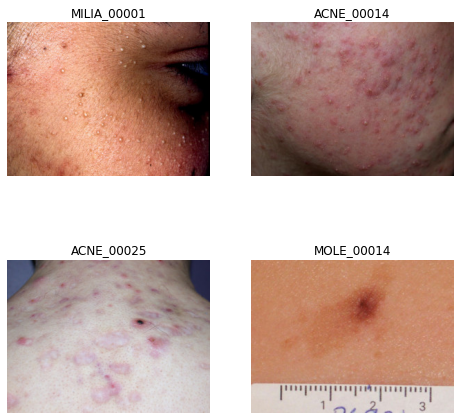

In [31]:
# sampling
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 2
j = 0
for i in range(columns*rows):
    img = plt.imread(os.path.join(unk_dir, unk_df['image_id'][i]+".jpg"))
    fig.add_subplot(rows, columns, i+1)
    plt.title(unk_df['image_id'][i])
    plt.imshow(img)
    plt.axis("off")
plt.show()

## Data Preparation

In [11]:
# copy images from src_dir to dst_dir
def copy_images(dataframe, src_dir, dst_dir):
    list_src_dir = os.listdir(src_dir)

    count = 0
    for _, row in dataframe.iterrows(): 
        filename = row['image']

        if filename in list_src_dir:
            src = os.path.join(src_dir, filename)
            dst = os.path.join(dst_dir, filename) 
            if shutil.copyfile(src, dst):
                count += 1
    
    print(count, "images copied from", src_dir)

### Train and Validation Set

#### HMNIST

##### Drop Duplicates

In [114]:
# drop duplicate lesions to avoid validation having the same image as train 
hmnist_df = raw_hmnist_df.drop_duplicates(subset="lesion_id", keep="first", ignore_index=True)
hmnist_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
2,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
3,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back


##### Feature Selection

In [115]:
# drop unimportant column
hmnist_df = hmnist_df.drop(columns=['lesion_id', 'dx_type', 'age', 'sex', 'localization'])
hmnist_df.head()

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0026769,bkl
2,ISIC_0031633,bkl
3,ISIC_0029176,bkl
4,ISIC_0025837,bkl


##### Filename

In [116]:
# define filename from `image_id`
hmnist_df['image'] = hmnist_df['image_id']+".jpg"
hmnist_df.head()

,image_id,dx,image
0,ISIC_0027419,bkl,ISIC_0027419.jpg
1,ISIC_0026769,bkl,ISIC_0026769.jpg
2,ISIC_0031633,bkl,ISIC_0031633.jpg
3,ISIC_0029176,bkl,ISIC_0029176.jpg
4,ISIC_0025837,bkl,ISIC_0025837.jpg


##### Copy Images

In [15]:
# check the number of data
print(hmnist_df.shape[0], "images expected")
# copy images
copy_images(hmnist_df, os.path.join(hmnist_dir, "HAM10000_images_part_1"), images_dir)
copy_images(hmnist_df, os.path.join(hmnist_dir, "HAM10000_images_part_2"), images_dir)

7470 images expected
4047 images copied from /home/aulia/dermanalyze/mnist-ham10000/HAM10000_images_part_1
3423 images copied from /home/aulia/dermanalyze/mnist-ham10000/HAM10000_images_part_2


#### ISIC-2018 Validation

##### Data Formatting

In [117]:
# convert one-hot into normal row
isicval_dxs = [column.lower() for _, row in raw_isicval_df.iterrows() for column in raw_isicval_df.columns[1:] if row[column] == 1]
isicval_data = [[image_id, dx] for image_id, dx in zip(raw_isicval_df['image'], isicval_dxs)]
isicval_df = pd.DataFrame(isicval_data, columns = ['image_id', 'dx'])
isicval_df.head()

,image_id,dx
0,ISIC_0034321,nv
1,ISIC_0034322,nv
2,ISIC_0034323,bcc
3,ISIC_0034324,nv
4,ISIC_0034325,nv


##### Filename

In [118]:
# define filename from `image_id`
isicval_df['image'] = isicval_df['image_id']+".jpg"
isicval_df.head()

,image_id,dx,image
0,ISIC_0034321,nv,ISIC_0034321.jpg
1,ISIC_0034322,nv,ISIC_0034322.jpg
2,ISIC_0034323,bcc,ISIC_0034323.jpg
3,ISIC_0034324,nv,ISIC_0034324.jpg
4,ISIC_0034325,nv,ISIC_0034325.jpg


##### Copy Images

In [18]:
# check the number of data
print(isicval_df.shape[0], "images expected")
# copy images
copy_images(isicval_df, os.path.join(isic18_val_dir, "ISIC2018_Task3_Validation_Input"), images_dir)

193 images expected
193 images copied from /home/aulia/dermanalyze/isic18-val/ISIC2018_Task3_Validation_Input


#### ISIC Archieve

##### Drop Duplicates

In [119]:
# drop duplicate data (`image_id`)
isicarv_df = raw_isicarv_df.drop_duplicates(subset="image_id", keep="first", ignore_index=True)
isicarv_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,5436e3acbae478396759f0d3,ISIC_0000002,mel,histopathology,60.0,female,upper extremity
1,5436e3acbae478396759f0d7,ISIC_0000004,mel,histopathology,80.0,male,posterior torso
2,5436e3adbae478396759f0e9,ISIC_0000013,mel,histopathology,30.0,female,posterior torso
3,5436e3aebae478396759f0fb,ISIC_0000022,mel,histopathology,55.0,female,lower extremity
4,5436e3aebae478396759f103,ISIC_0000026,mel,histopathology,30.0,female,lower extremity


In [120]:
isicarv_df.shape[0]

2941

##### Feature Selection

In [121]:
# drop unimportant column
isicarv_df = isicarv_df.drop(columns=['lesion_id', 'dx_type', 'age', 'sex', 'localization'])
isicarv_df.head()

,image_id,dx
0,ISIC_0000002,mel
1,ISIC_0000004,mel
2,ISIC_0000013,mel
3,ISIC_0000022,mel
4,ISIC_0000026,mel


##### Filename

In [122]:
# define filename from `image_id`
isicarv_df['image'] = isicarv_df['image_id']+".jpg"
isicarv_df.head()

,image_id,dx,image
0,ISIC_0000002,mel,ISIC_0000002.jpg
1,ISIC_0000004,mel,ISIC_0000004.jpg
2,ISIC_0000013,mel,ISIC_0000013.jpg
3,ISIC_0000022,mel,ISIC_0000022.jpg
4,ISIC_0000026,mel,ISIC_0000026.jpg


##### Copy Images

In [106]:
# check the number of data
print(isicarv_df.shape[0], "images expected")
# copy images
copy_images(isicarv_df, os.path.join(isicarv_dir, "ISIC-images", "Images"), images_dir)

2941 images expected
2941 images copied from /home/aulia/dermanalyze/isic-archieve/ISIC-images/Images


#### DermNet NZ

##### Filename

In [123]:
# define filename from `image_id`
dermnetnz_df['image'] = dermnetnz_df['image_id']+".jpg"
dermnetnz_df.head()

,image_id,dx,image
0,DF_00019,df,DF_00019.jpg
1,DF_00009,df,DF_00009.jpg
2,DF_00004,df,DF_00004.jpg
3,DF_00018,df,DF_00018.jpg
4,DF_00022,df,DF_00022.jpg


##### Copy Images

In [24]:
# check the number of data
print(dermnetnz_df.shape[0], "images expected")
# copy images
for label in os.listdir(dermnetnz_dir):
    copy_images(dermnetnz_df, os.path.join(dermnetnz_dir, label), images_dir)

406 images expected
21 images copied from /home/aulia/dermanalyze/dermnetnz/df
62 images copied from /home/aulia/dermanalyze/dermnetnz/bkl
75 images copied from /home/aulia/dermanalyze/dermnetnz/vasc
38 images copied from /home/aulia/dermanalyze/dermnetnz/bcc
63 images copied from /home/aulia/dermanalyze/dermnetnz/akiec
147 images copied from /home/aulia/dermanalyze/dermnetnz/mel
0 images copied from /home/aulia/dermanalyze/dermnetnz/nv


#### Unknown

##### Filename

In [126]:
# define filename from `image_id`
unk_df['image'] = unk_df['image_id']+".jpg"
unk_df.head()

,image_id,dx,image
0,MILIA_00001,unk,MILIA_00001.jpg
1,ACNE_00014,unk,ACNE_00014.jpg
2,ACNE_00025,unk,ACNE_00025.jpg
3,MOLE_00014,unk,MOLE_00014.jpg
4,ACNE_00005,unk,ACNE_00005.jpg


##### Copy Images

In [29]:
# check the number of data
print(unk_df.shape[0], "images expected")
# copy images
copy_images(unk_df, unk_dir, images_dir)

96 images expected
96 images copied from /home/aulia/dermanalyze/unknown


#### Apply Color Constancy

In [45]:
def shade_of_gray(img, power=6, gamma=None):
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        lookuptable = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            lookuptable[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, lookuptable)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1 / (rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    img = np.clip(img, a_min=0, a_max=255)
    return img.astype(img_dtype)

In [46]:
def apply_cc(src_dir, dst_dir):       
    for fname in os.listdir(src_dir):
        img = cv2.imread(os.path.join(src_dir, fname), cv2.IMREAD_COLOR)
        cc_img = shade_of_gray(img) # apply cc w/o gamma
        cv2.imwrite(os.path.join(dst_dir, fname), cc_img)

In [108]:
apply_cc(images_dir, cc_images_dir)

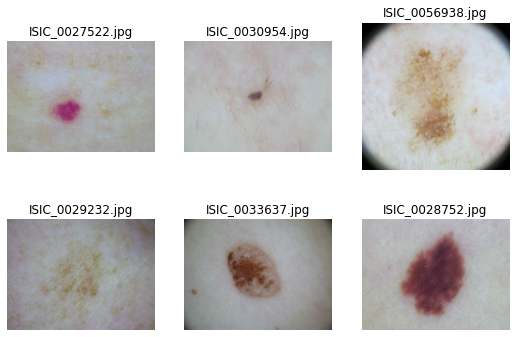

In [109]:
# check results
fig = plt.figure(figsize=(9, 6))
columns, rows = 3, 2
cc_fnames = os.listdir(cc_images_dir)
for i in range(columns*rows):
    img = plt.imread(os.path.join(cc_images_dir, cc_fnames[i]))
    fig.add_subplot(rows, columns, i+1)
    plt.title(cc_fnames[i])
    plt.imshow(img)
    plt.axis("off")
plt.show()

#### Concatenate Dataframes (exc. Unknown Class)

In [127]:
final_df = pd.concat([hmnist_df, isicval_df, isicarv_df, dermnetnz_df], ignore_index=True)
final_df

,image_id,dx,image
0,ISIC_0027419,bkl,ISIC_0027419.jpg
1,ISIC_0026769,bkl,ISIC_0026769.jpg
2,ISIC_0031633,bkl,ISIC_0031633.jpg
3,ISIC_0029176,bkl,ISIC_0029176.jpg
4,ISIC_0025837,bkl,ISIC_0025837.jpg
...,...,...,...
11005,MEL_00012,mel,MEL_00012.jpg
11006,MEL_00048,mel,MEL_00048.jpg
11007,MEL_00067,mel,MEL_00067.jpg
11008,MEL_00106,mel,MEL_00106.jpg


In [128]:
# view final distribution
final_df['dx'].value_counts()

nv       5526
mel      1682
bkl      1411
bcc       980
akiec     899
vasc      291
df        221
Name: dx, dtype: int64

In [129]:
# save final_df and unk_df to csv format
final_df.to_csv(os.path.join(base_dir, "lesion_df.csv"), encoding='utf-8', index=False)
unk_df.to_csv(os.path.join(base_dir, "unk_df.csv"), encoding='utf-8', index=False)

## Data Augmentation

In [15]:
# initialize image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    brightness_range=[0.9, 1.1],
    zoom_range=[0, 0.2], 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest') 
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

## Modelling

In [16]:
def build_model():
    pre_trained_model = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False, input_shape=(256, 256, 3))
    for layer in pre_trained_model.layers:
        if layer.name == 'block5a_expand_conv':
            break
        layer.trainable = False
    last_output = pre_trained_model.output
    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(8, activation='softmax')(x)
    return tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

## Evaluation

In [17]:
batch_size = 5
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

In [18]:
# load saved df
lesion_df = pd.read_csv(os.path.join(base_dir, "lesion_df.csv"))
unk_df = pd.read_csv(os.path.join(base_dir, "unk_df.csv"))
labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc', 'unk']

In [19]:
# split using StratifiedKFold, where n_split = 5 and val size = 20% (1/5)
skf = StratifiedKFold(n_splits = 5, shuffle = True) 

### Metrics

In [5]:
class BalancedAccuracy(Metric):
    def __init__(self, thresholds=None, top_k=None, class_id=None, name="balanced_accuracy", dtype=None):
        super(BalancedAccuracy, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(thresholds, default_threshold=default_threshold)
        self.true_positives = self.add_weight('true_positives', shape=(len(self.thresholds),), initializer=init_ops.zeros_initializer)
        self.true_negatives = self.add_weight('true_negatives', shape=(len(self.thresholds),), initializer=init_ops.zeros_initializer)
        self.false_positives = self.add_weight('false_positives', shape=(len(self.thresholds),), initializer=init_ops.zeros_initializer)
        self.false_negatives = self.add_weight('false_negatives', shape=(len(self.thresholds),), initializer=init_ops.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives,
                metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            top_k=self.top_k,
            class_id=self.class_id,
            sample_weight=sample_weight)

    def result(self):
        result = (math_ops.div_no_nan(self.true_positives, self.true_positives + self.false_negatives) +
                  math_ops.div_no_nan(self.true_negatives, self.true_negatives + self.false_positives)) / 2
        return result[0] if len(self.thresholds) == 1 else result

    def reset_state(self):
        num_thresholds = len(to_list(self.thresholds))
        K.batch_set_value(
            [(v, np.zeros((num_thresholds,))) for v in self.variables])

    def get_config(self):
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(BalancedAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

balanced_accuracy = BalancedAccuracy()

### Callbacks

In [ ]:
def scheduler(epoch, lr):
    if epoch%25 == 0:
        return lr * 0.5
    else:
        return lr 
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoints_dir, "model_{epoch:05d}-{balanced_accuracy:.3f}-{loss:.5f}-{val_loss:.5f}.h5"), 
    monitor='val_balanced_accuracy', 
    save_best_only=True, 
    mode='max'
    period=10)

### Tuner

In [18]:
def model_builder(hp):
    resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(320, 240, 3))
    inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=(320, 240, 3))
    efficientnet = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False, input_shape=(320, 240, 3))
    pre_trained_model_name = hp.Choice('base_model', values=['resnet', 'inception', 'efficientnet'])
    if pre_trained_model_name == 'resnet':
        pre_trained_model = resnet
        last_layer_name = hp.Choice('last_layer_r', values=['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out'])
        trainable_layer_name = hp.Choice('trainable_layer_1', values=['conv4_block3_1_conv']) if last_layer_name == 'conv5_block1_out' else \
            hp.Choice('trainable_layer_2', values=['conv4_block3_1_conv', 'conv4_block4_1_conv']) if last_layer_name == 'conv5_block2_out' else \
            hp.Choice('trainable_layer_3', values=['conv4_block4_1_conv'])
    elif pre_trained_model_name == 'inception':
        pre_trained_model = inception
        last_layer_name = hp.Choice('last_layer_i', values=['mixed8', 'mixed9', 'mixed10'])
        trainable_layer_name = hp.Choice('trainable_layer_8', values=['conv2d_54']) if last_layer_name == 'mixed8' else \
            hp.Choice('trainable_layer_9', values=['conv2d_54', 'conv2d_64']) if last_layer_name == 'mixed9' else \
            hp.Choice('trainable_layer_10', values=['conv2d_64'])
    elif pre_trained_model_name == 'efficientnet':
        pre_trained_model = efficientnet
        last_layer_name = hp.Choice('last_layer_e', values=['top_activation'])
        trainable_layer_name = hp.Choice('trainable_layer_e', values=['block5a_expand_conv']) 
    
    for layer in pre_trained_model.layers:
        if layer.name == trainable_layer_name:
            break
        layer.trainable = False
    
    last_layer = pre_trained_model.get_layer(last_layer_name)
    last_output = last_layer.output
    x = tf.keras.layers.Flatten()(last_output)

    for i in range(hp.Int('layers', min_value=0, max_value=4, step=1)):
        dim = hp.Int(f'layer_{i + 1}_dim', min_value=256, max_value=1025, step=256)
        x = tf.keras.layers.Dense(dim, activation=tf.nn.relu, name=f'dense_{i + 1}x{dim}')(x)
    
    if hp.Boolean("is_dropout"):
        x = tf.keras.layers.Dropout(hp.Float('dropout', 0.1, 0.4, step=0.1))(x)

    x = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(
        optimizer = "adam", 
        loss = "categorical_crossentropy", 
        metrics = [balanced_accuracy])
    
    return model

In [ ]:
for train_index, val_index in skf.split(lesion_df['image'], lesion_df['dx']):    
    tf.keras.backend.clear_session()

    train_data = pd.concat([lesion_df.iloc[train_index], unk_df], ignore_index=True)
    val_data = lesion_df.iloc[val_index]
    
    train_generator = train_datagen.flow_from_dataframe(
        train_data,
        directory=cc_images_dir,
        x_col='image',
        y_col='dx',
        target_size=(256, 256),
        classes=labels,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)
    val_generator = val_datagen.flow_from_dataframe(
        val_data,
        directory=cc_images_dir,
        x_col='image',
        y_col='dx',
        target_size=(256, 256),
        classes=labels,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False)
    
    counter = Counter(train_generator.classes)                      
    total = float(sum(counter.values()))
    class_weights = {class_id : total/num_images for class_id, num_images in counter.items()} 

    tuner = kt.BayesianOptimization(
        model_builder, 
        objective=kt.Objective('val_balanced_accuracy', direction="max"), 
        max_trials=50,
        directory=base_dir, 
        project_name='tuning')
    
    tuner.search(
        train_generator, 
        epochs = 10,
        class_weight = class_weights,
        steps_per_epoch = train_generator.n//train_generator.batch_size, 
        validation_data = val_generator,
        validation_steps = val_generator.n//val_generator.batch_size,
        callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
    )
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    print(best_hps.values)

    print(tuner.results_summary(num_trials=3))

    break

### Training

In [ ]:
i = 1
for train_index, val_index in skf.split(lesion_df['image'], lesion_df['dx']):    
    tf.keras.backend.clear_session()

    train_data = pd.concat([lesion_df.iloc[train_index], unk_df], ignore_index=True)
    val_data = lesion_df.iloc[val_index]
    
    train_generator = train_datagen.flow_from_dataframe(
        train_data,
        directory=cc_images_dir,
        x_col='image',
        y_col='dx',
        target_size=(256, 256),
        classes=labels,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)
    val_generator = val_datagen.flow_from_dataframe(
        val_data,
        directory=cc_images_dir,
        x_col='image',
        y_col='dx',
        target_size=(256, 256),
        classes=labels,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False)
    
    counter = Counter(train_generator.classes)
    total = float(sum(counter.values()))
    class_weights = {class_id : total/num_images for class_id, num_images in counter.items()} 

    model = build_model()

    model.compile(
        optimizer = "adam", 
        loss = "categorical_crossentropy", 
        metrics = [balanced_accuracy]) 

    history = model.fit(
        train_generator, 
        epochs = 100,
        class_weight = class_weights,
        steps_per_epoch = train_generator.n//train_generator.batch_size, 
        validation_data = val_generator,
        validation_steps = val_generator.n//val_generator.batch_size,
        callbacks=[lr_scheduler, model_checkpoint],
        verbose=0)
    
    acc = history.history['balanced_accuracy']
    val_acc = history.history['val_balanced_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    _, (ax, bx) = plt.subplots(2)
    ax.plot(epochs, acc)
    ax.plot(epochs, val_acc)
    ax.set_title('Training and validation accuracy')
    bx.plot(epochs, loss)
    bx.plot(epochs, val_loss)    
    bx.set_title('Training and validation loss')
    plt.show()
    
    results = model.evaluate(val_generator)
    results = dict(zip(model.metrics_names, results))
    print(results)

    # plot confusion matrix from predicting val
    y_pred = np.argmax(model.predict(val_generator), axis=1)
    cm = confusion_matrix(val_datagen.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show() 
    
    tf.saved_model.save(model, os.path.join(models_dir, i))
    i+=1 
    
    VALIDATION_ACCURACY.append(results['balanced_accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    # break

print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)

## Deployment

### Convert Model

In [4]:
version = "1.0.0"
tflite_model_path = os.path.join(tflite_dir, f"model_{version}.tflite")

In [6]:
model = tf.keras.models.load_model(os.path.join(checkpoints_dir, "model_00020.h5"), custom_objects={'BalancedAccuracy': BalancedAccuracy})

In [8]:
export_dir = os.path.join(models_dir, version)
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: C:\Users\aulia\Bangkit\Dermanalyze-ML\models\1.0.0\assets


INFO:tensorflow:Assets written to: C:\Users\aulia\Bangkit\Dermanalyze-ML\models\1.0.0\assets


In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = pathlib.Path(tflite_model_path)
tflite_model_file.write_bytes(tflite_model)

44513880

### Inference

In [5]:
labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc', 'unk']

In [6]:
# read image
img_path = os.path.join(hmnist_test_dir, "ISIC2018_Task3_Test_Images", "ISIC_0034611.jpg")
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_dtype = img.dtype

# apply shade of gray color constancy
img = img.astype('float32')
img_power = np.power(img, 6)
rgb_vec = np.power(np.mean(img_power, (0,1)), 1/6)
rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
rgb_vec = rgb_vec/rgb_norm
rgb_vec = 1 / (rgb_vec*np.sqrt(3))
img = np.multiply(img, rgb_vec)
img = np.clip(img, a_min=0, a_max=255)
img = img.astype(img_dtype)

# convert to tensor
img_tensor = tf.convert_to_tensor(img)
# resize into input size (256, 256)
img_tensor = tf.image.resize(img_tensor, (256, 256)) 
# rescale img [0, 1]
img_tensor = tf.cast(img_tensor, dtype=tf.float32) / tf.constant(256, dtype=tf.float32) 
# add dimension for batch
input_data = tf.expand_dims(img_tensor, axis=0) 

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]["index"], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]["index"])
print(tflite_results)

# References

Technique:
* C. Barata, M. E. Celebi, and J. S. Marques, “Improving dermoscopy image classification using color constancy,” IEEE journal of biomedical and health informatics, vol. 19, no. 3, pp. 1146–1152, 2015.

Dataset:
* Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 (2018). doi: 10.1038/sdata.2018.161
* https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
* https://challenge.isic-archive.com/data/#2018
* https://www.kaggle.com/datasets/jnegrini/skin-lesions-act-keratosis-and-melanoma
* https://dermnetnz.org/image-library
* https://ijdvl.com/the-utility-of-dermoscopy-in-the-diagnosis-of-evolving-lesions-of-vitiligo/
* https://www.researchgate.net/publication/263710653_In-vivo_imaging_of_psoriatic_lesions_with_polarization_multispectral_dermoscopy_and_multiphoton_microscopy
* https://www.researchgate.net/publication/220451508_Systematic_design_of_a_cross-polarized_dermoscope_for_visual_inspection_and_digital_imaging
* https://www.researchgate.net/publication/270658281_Detecting_melanoma_in_dermoscopy_images_using_scale_adaptive_local_binary_patterns
* https://www.ijdpdd.com/article.asp?issn=2349-6029;year=2017;volume=4;issue=2;spage=27;epage=30;aulast=Nirmal
* https://www.semanticscholar.org/paper/Dermoscopy-in-near-full-facial-transplantation.-Kami%C5%84ska-Winciorek-Giebel/54f1a4de702261cafaf5fbdf129f1d2326650b92#paper-header
* http://www.odermatol.com/issue-in-html/2018-2-34-nevus/